In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Wczytanie danych

In [287]:
df = pd.read_stata("HCMST 2017 fresh sample for public sharing draft v1.1.dta")

## Przygotwanie zmiennych

Najpierw konwertujemy odpowiedź `S1` na zmienną binarną, gdzie 1 odpowiada informacji `Yes, I am Married`

In [288]:
df['y'] = 1 - df['S1'].cat.codes

### Wybrane zmienne

Do modelu wybrałem następujące zmienne  
1) kategoryczne:  
  a) `Q23` - Between you and [Partner name], who earned more income in 2016,  
  b) `Q28` - Did your parents know [Partner name]’s parents before you met [Partner name]?,  
2) uporządkowane:  
  a) `ppp20072` - Q27: How often do you attend religious services?,  
  b) `w6_how_many` - How many Different people besides [Partner name] have you met for dating, or rom   

Wszystkie zmienne są zakodowane przez kategorię, które odkoduję.

In [289]:
df = df.dropna(subset=['Q23', 'Q28', 'ppp20072', 'w6_how_many'])

In [290]:
X = df[['Q23', 'Q28', 'ppp20072', 'w6_how_many']].apply(lambda x: x.cat.codes, axis=0)
y = df['y']

In [291]:
X.shape

(225, 4)

Zostało nam 225 obserwacji co oznacza, że nie ma sensu uczyć modelu o dużej pojemności. Z tego powodu wybrałem las losowy o 25 drzewach i maksymalnej głębokości 3.

Stworzymy dodatkowo słowniki do zmiennych kategorycznych by łatwiej odwikłać potem kategorię.

In [292]:
d_ppp20072 = dict(enumerate(df['ppp20072'].cat.categories))
d_w6_how_many = dict(enumerate([cat.split(".")[0] for cat in df['w6_how_many'].cat.categories]))

In [293]:
d = {
    'ppp20072': d_ppp20072,
    'w6_how_many': d_w6_how_many
}

## Budowa modelu

In [294]:
from sklearn.ensemble import RandomForestClassifier

In [295]:
rf = RandomForestClassifier(n_estimators=25, max_depth=4)

In [296]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Ceteris Paribus

Ponieważ korzystam tylko z zmiennych uporządkowanych funkcja `ceterus_paribus` będzie poprostu przyjmowała wszystkie wartości możliwe dla danej zmiennej.

In [297]:
X.iloc[150]

Q23            1
Q28            2
ppp20072       6
w6_how_many    1
Name: 2512, dtype: int8

In [298]:
def ceteris_paribus(df, obs, model, variable):
    unique_values = sorted(list(df[variable].unique()))
    this_obs_value = [unique_values.index(df.iloc[obs].loc[variable])]
    preds = []
    for value in unique_values:
        X_temp = df.iloc[obs, :]
        X_temp[variable] = value
        preds.append(rf.predict_proba(X_temp.values.reshape(1,-1))[0, 1])
    unique_values = list(map(lambda x: d[variable][x], unique_values))
    plt.plot(unique_values, preds, label="ceteris_paribus")
    plt.scatter(this_obs_value, 
                preds[this_obs_value[0]])
    #return preds, unique_values

Będziemy analizować obserwację 150 czyli:

In [299]:
df.loc[X.index,:].iloc[150].loc[X.columns]

Q23                                                I earned more
Q28                                                           No
ppp20072                                                   Never
w6_how_many    One person. I met only one person besides [Par...
Name: 2512, dtype: object

Osobę ktora:  
1) zarabiała więcej od partnera,   
2) jej rodzice nie znali rodziców partnera przed poznaniem,  
3) Nigdy nie bierze udziału w obrzędach religijnych,  
4) Przed spotkaniem swojego partnera spoktykała się tylko z 1 inną osobą.

## Wykresy Marginal Plots

In [300]:
def m_plot(X, variable, model):
    unique_values = sorted(list(X[variable].unique()))
    preds = []
    for value in unique_values:
        X_single = X[X[variable] == value]
        preds.append(model.predict_proba(X_single.values)[:, 1].mean())
    unique_values = list(map(lambda x: d[variable][x], unique_values))
    plt.plot(unique_values, preds, label="M_plot")

## Ceteris Paribus i Marginal Plots

### w6_how_many

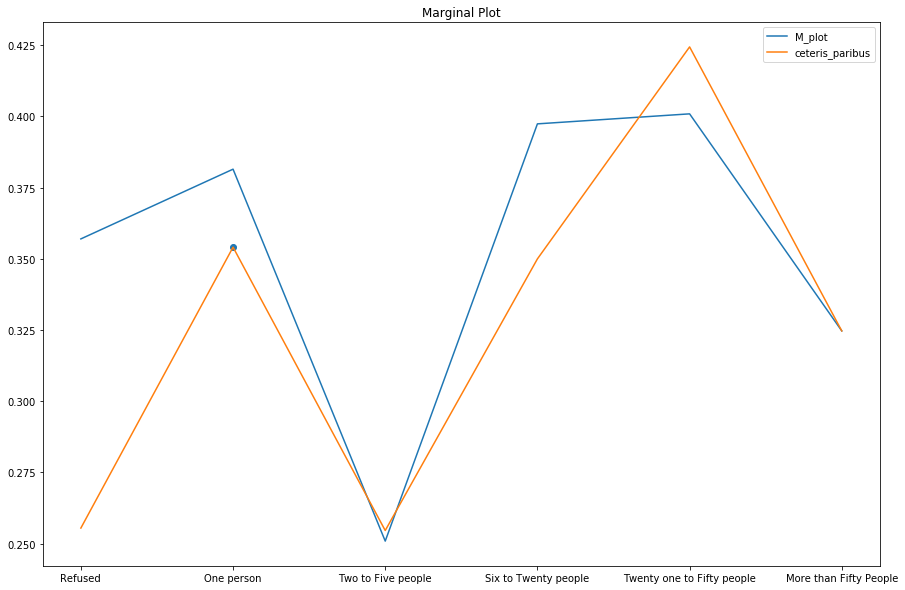

In [301]:
plt.figure(figsize=(15,10))
m_plot(X, "w6_how_many", rf)
plt.title("Marginal Plot")
ceteris_paribus(X, 150, rf, "w6_how_many")
plt.legend()
pass

Profile M_plot i Ceteris paribus są bardzo podobne dla tej zmiennej. Może to wynikać z tego, że obserwacja jest podobna do średniej jeśli chodzi o inne cechy.

### ppp20072

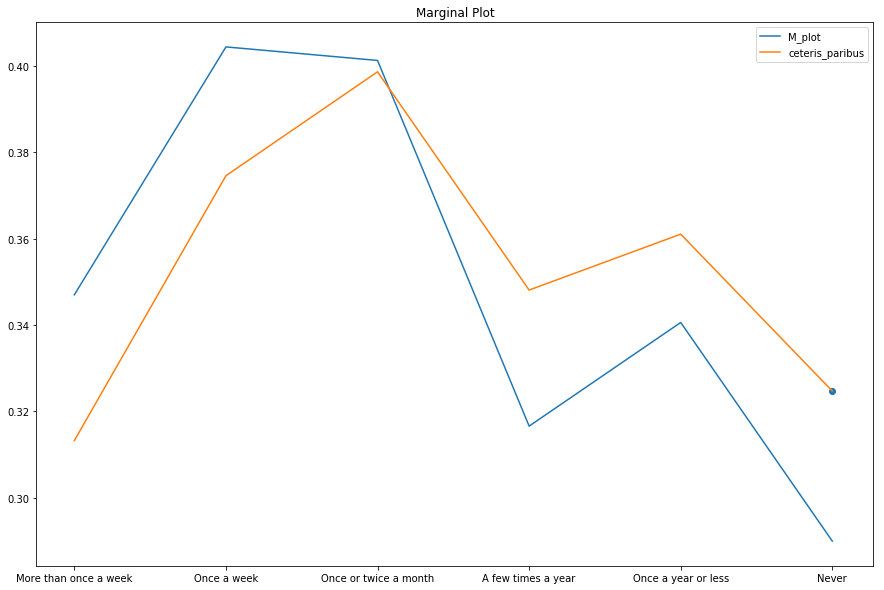

In [304]:
plt.figure(figsize=(15,10))
m_plot(X, "ppp20072", rf)
plt.title("Marginal Plot")
ceteris_paribus(X, 150, rf, "ppp20072")
plt.legend()
pass

Tutaj też wykresy są bardzo podobne, jedyne co możemy zauważyć, to to że nasza konkretna osoba ma trochę większe p-stwo bycia zameżną w stosunku do osób, które kilka razy w roku lub rzadziej biorą udział w obrzędach religijnych. Może to być skorelowane z zmienną `w6_how_many`, która mówi że ta osoba spotykała się do tej pory z tylko jednym partnerem. Taka osoba mogła np. wcześniej być bardziej religijna i wziąć ślub, i teraz zmieniła światopogląd, w stosunku do ludzi, którzy często zmieniają partnerów i mogą być w związku już po zmianie religijności.